In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import glob
import os

In [14]:
path = "amostra_PETS.csv"

In [15]:
all_files = glob.glob(path + "/*.csv")

In [16]:
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [5]:
num_linhas = df.shape[0]
print(f"O DataFrame tem {num_linhas} linhas.")

O DataFrame tem 55870 linhas.


In [8]:
quantidade_ocorrencias = df['Available'].value_counts()

# Mostrar os resultados
quantidade_0 = quantidade_ocorrencias.get(0, 0)
quantidade_1 = quantidade_ocorrencias.get(1, 0)

print("Quantidade de ocorrências de 0 na coluna 'Available':", quantidade_0)
print("Quantidade de ocorrências de 1 na coluna 'Available':", quantidade_1)

Quantidade de ocorrências de 0 na coluna 'Available': 34004
Quantidade de ocorrências de 1 na coluna 'Available': 21866


Balanceamento

In [10]:
# Amostrar aleatoriamente o mesmo número de ocorrências para cada valor
amostra_balanceada_0 = df[df['Available'] == 0].sample(n=21866, random_state=42)
amostra_balanceada_1 = df[df['Available'] == 1].sample(n=21866, random_state=42)

# Concatenar as amostras para criar um DataFrame balanceado
df_balanceado = pd.concat([amostra_balanceada_0, amostra_balanceada_1])

# Mostrar o tamanho do DataFrame balanceado
print("Tamanho do DataFrame balanceado:", df_balanceado.shape[0])

# Mostrar a distribuição dos valores na coluna "Available"
print(df_balanceado['Available'].value_counts())

Tamanho do DataFrame balanceado: 43732
Available
0    21866
1    21866
Name: count, dtype: int64


In [11]:
df = df_balanceado

In [12]:
# Ordenar o DataFrame em ordem decrescente com base na coluna "FinalPrice"
maiores_final_prices = df.sort_values(by="FinalPrice", ascending=False)

# Mostrar os primeiros registros para ver os maiores valores da coluna "FinalPrice"
maiores_final_prices.head()


,Available,SuggestedPrice,FinalPrice,RandomPrecosNegativos,RandomPrecosDiscrepantes,RandomPrecosDiscrepantesFator,Customer,Department,Category,Brand,Product,Retailer,Ano,Mês,Dia
50838,1,85.20,992.48,1,1,6.6,Unilever,Home Care,PETS,CAFUNE,Tapete higienico Cafuné Slim 30 unidades,Carone,2023,6,15
50837,1,85.20,992.48,1,1,6.6,Unilever,Home Care,PETS,CAFUNE,Tapete higienico Cafuné Slim 30 unidades,Carone,2023,6,15
50836,1,85.20,992.48,1,1,6.6,Unilever,Home Care,PETS,CAFUNE,Tapete higienico Cafuné Slim 30 unidades,Carone,2023,6,15
50839,1,85.20,992.48,1,1,6.6,Unilever,Home Care,PETS,CAFUNE,Tapete higienico Cafuné Slim 30 unidades,Carone,2023,6,15
48402,1,78.67,920.68,1,1,7.6,Unilever,Home Care,PETS,CAFUNE,Tapete higienico Cafuné Slim 30 unidades,Magazine Luiza - Sages,2023,5,6


In [13]:
total_linhas = len(df)
print("Número total de linhas no DataFrame:", total_linhas)


Número total de linhas no DataFrame: 43732


In [15]:
quantidade_nulos_por_coluna = df.isnull().sum()
print(quantidade_nulos_por_coluna)


Available                            0
SuggestedPrice                      85
FinalPrice                       23507
RandomPrecosNegativos                0
RandomPrecosDiscrepantes             0
RandomPrecosDiscrepantesFator        0
Customer                             0
Department                           0
Category                             0
Brand                                0
Product                              0
Retailer                             0
Ano                                  0
Mês                                  0
Dia                                  0
dtype: int64


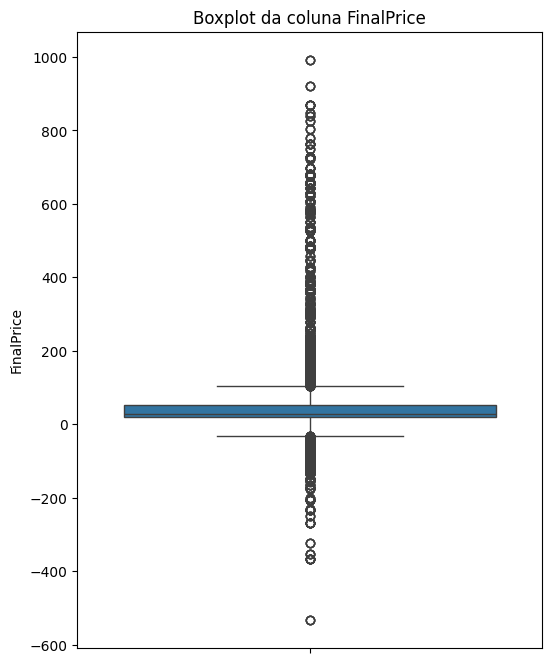

In [13]:
plt.figure(figsize=(6, 8))  # Ajuste o tamanho conforme desejado
sns.boxplot(y='FinalPrice', data=df)
plt.title('Boxplot da coluna FinalPrice')
plt.ylabel('FinalPrice')
plt.show()

# MACHINE LEARNING


Classe customizada para aplicar IsolationForest como um Transforme

In [17]:
class IsoForestTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.iso_forest = IsolationForest(contamination=0.1, random_state=42)

    def fit(self, X, y=None):
        self.iso_forest.fit(X)
        return self

    def transform(self, X):
        # Transformar os valores de -1, 1 para 0, 1
        return ((self.iso_forest.predict(X) == -1) * 1).reshape(-1, 1)

Separar treino e teste

In [18]:
X = df.drop(columns=['Available'])
y = df['Available']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorica

In [19]:
colunas_categoricas = ['SuggestedPrice', 'RandomPrecosNegativos', 
                       'RandomPrecosDiscrepantes', 'Customer', 'Department', 
                       'Category', 'Brand', 'Product', 'Retailer']


Preprocesso

In [21]:
# Definir a pipeline base
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), ['FinalPrice']),  # Substituir valores nulos pela mediana para variáveis numéricas
    ('cat', OneHotEncoder(), colunas_categoricas)               # Codificar one-hot para variáveis categóricas
], remainder='passthrough')

union = FeatureUnion([
    ('preprocessed', ColumnTransformer([
        ('num', 'passthrough', [0]), # passa o output do imputer sem modificações
        ('cat', 'passthrough', slice(1, None)) # passa o output do OneHotEncoder sem modificações
    ])),
    ('iso_forest', IsoForestTransformer()) # aplica o IsolationForest
])


Pipelines

In [23]:

# Pipeline com Decision Tree
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('union', union),
    ('classifier', DecisionTreeClassifier(max_depth=3))
])

# Pipeline com KNN
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('union', union),
    ('classifier', KNeighborsClassifier(n_neighbors=3))
])

# Pipeline com SVM
pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('union', union),
    ('classifier', SVC(kernel='rbf', C=1.0))
])
'''
pipeline_cross_validation = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), ['FinalPrice']),  # Substituir valores nulos pela mediana para variáveis numéricas
        ('cat', OneHotEncoder(), colunas_categoricas)               # Codificar one-hot para variáveis categóricas
    ], remainder='passthrough')),                                   # Manter as colunas não modificadas
    ('union', FeatureUnion([
        ('preprocessed', ColumnTransformer([
            ('num', 'passthrough', [0]), # passa o output do imputer sem modificações
            ('cat', 'passthrough', slice(1, None)) # passa o output do OneHotEncoder sem modificações
        ])),
        ('iso_forest', IsoForestTransformer()) # aplica o IsolationForest
    ])),
    ('classifier', DecisionTreeClassifier())                        # Classificador de árvore de decisão
])
'''


"\npipeline_cross_validation = Pipeline([\n    ('preprocessor', ColumnTransformer([\n        ('num', SimpleImputer(strategy='median'), ['FinalPrice']),  # Substituir valores nulos pela mediana para variáveis numéricas\n        ('cat', OneHotEncoder(), colunas_categoricas)               # Codificar one-hot para variáveis categóricas\n    ], remainder='passthrough')),                                   # Manter as colunas não modificadas\n    ('union', FeatureUnion([\n        ('preprocessed', ColumnTransformer([\n            ('num', 'passthrough', [0]), # passa o output do imputer sem modificações\n            ('cat', 'passthrough', slice(1, None)) # passa o output do OneHotEncoder sem modificações\n        ])),\n        ('iso_forest', IsoForestTransformer()) # aplica o IsolationForest\n    ])),\n    ('classifier', DecisionTreeClassifier())                        # Classificador de árvore de decisão\n])\n"

Grid Search

In [25]:
# Definir os parâmetros para o Grid Search detalhado
param_grid_dt = {
    'classifier__max_depth': [2, 3, 4, 5]
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9]
}

# Criar o objeto Grid Search com validação cruzada de 5 folds para Decision Tree
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='accuracy')

# Criar o objeto Grid Search com validação cruzada de 5 folds para KNN
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='accuracy')

# Treinar o grid search para Decision Tree
grid_search_dt.fit(X_train, y_train)

# Treinar o grid search para KNN
grid_search_knn.fit(X_train, y_train)

# Obter o melhor modelo de Decision Tree
best_model_dt = grid_search_dt.best_estimator_

# Obter o melhor modelo de KNN
best_model_knn = grid_search_knn.best_estimator_

# Fazer previsões no conjunto de teste para Decision Tree
y_pred_dt = best_model_dt.predict(X_test)

# Fazer previsões no conjunto de teste para KNN
y_pred_knn = best_model_knn.predict(X_test)

# Calcular a acurácia para Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Acurácia (Decision Tree):", accuracy_dt)

# Calcular a acurácia para KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Acurácia (KNN):", accuracy_knn)

# Exibir o melhor estimador encontrado pelo Grid Search para Decision Tree
print("Melhor Estimador (Decision Tree):")
print(best_model_dt)

# Exibir o melhor estimador encontrado pelo Grid Search para KNN
print("Melhor Estimador (KNN):")
print(best_model_knn)


Acurácia (Decision Tree): 0.943980793414885
Acurácia (KNN): 0.9973705270378416
Melhor Estimador (Decision Tree):
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['FinalPrice']),
                                                 ('cat', OneHotEncoder(),
                                                  ['SuggestedPrice',
                                                   'RandomPrecosNegativos',
                                                   'RandomPrecosDiscrepantes',
                                                   'Customer', 'Department',
                                                   'Category', 'Brand',
                                                   'Product', 'Retailer'])])),
                ('union',
                 FeatureUnion(tran

In [26]:


# Salvar o melhor modelo de Decision Tree
joblib.dump(best_model_dt, 'best_model_dt.joblib')

# Salvar o melhor modelo de KNN
joblib.dump(best_model_knn, 'best_model_knn.joblib')


['best_model_knn.joblib']

Arvore de decisão

In [ ]:
# Treinar e avaliar o modelo Decision Tree
pipeline_dt.fit(X_train, y_train)
y_pred_dt = pipeline_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("Acurácia (Decision Tree):", accuracy_dt)
print("Matriz de Confusão (Decision Tree):")
print(conf_matrix_dt)

Acurácia (Decision Tree): 0.9269463816165543
Matriz de Confusão (Decision Tree):
[[4255  108]
 [ 531 3853]]


 Modelo KNN

In [ ]:
# Treinar e avaliar o modelo KNN
pipeline_knn.fit(X_train, y_train)
y_pred_knn = pipeline_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

print("Acurácia (KNN):", accuracy_knn)
print("Matriz de Confusão (KNN):")
print(conf_matrix_knn)

Acurácia (KNN): 0.9973705270378416
Matriz de Confusão (KNN):
[[4353   10]
 [  13 4371]]


Modelo SVM


In [ ]:
# Treinar e avaliar o modelo SVM
pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print("Acurácia (SVM):", accuracy_svm)
print("Matriz de Confusão (SVM):")
print(conf_matrix_svm)

Acurácia (SVM): 0.5608780153195382
Matriz de Confusão (SVM):
[[4325   38]
 [3803  581]]


Gráfico da Matriz de Confusão

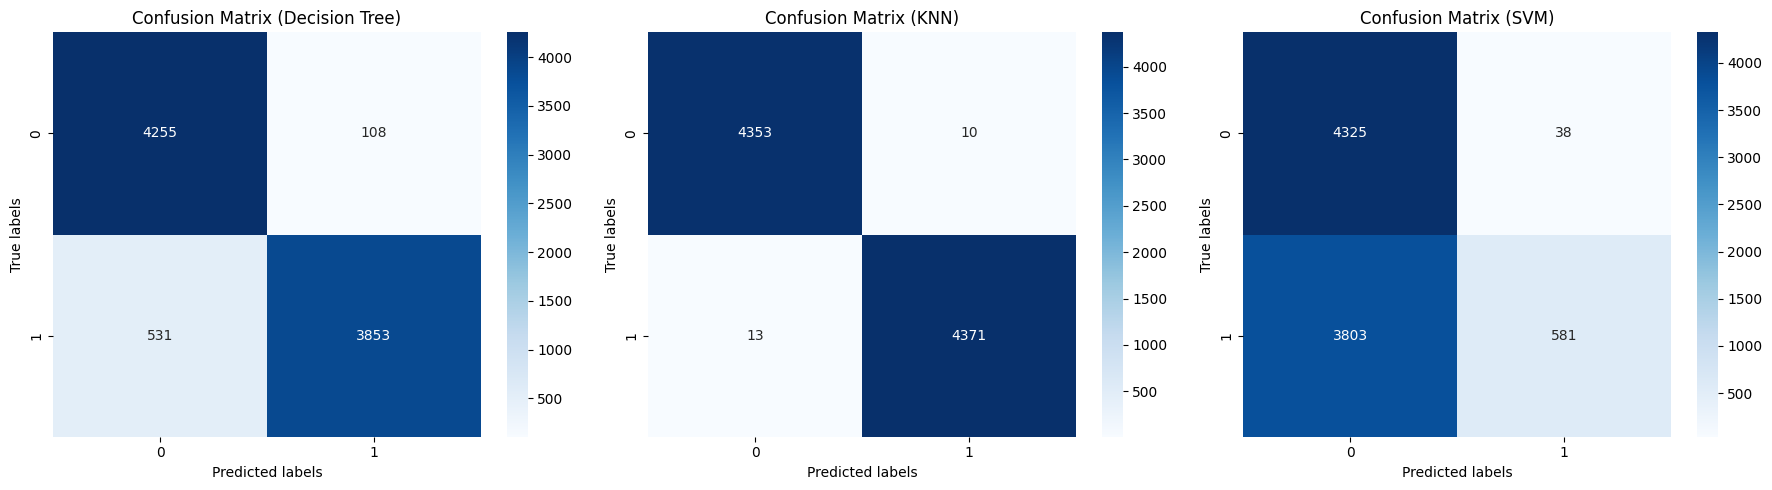

In [ ]:
# Plotar a matriz de confusão para Decision Tree
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix (Decision Tree)')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Plotar a matriz de confusão para KNN
plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix (KNN)')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Plotar a matriz de confusão para SVM
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix (SVM)')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.tight_layout()
plt.show()

Gráficos do Melhor modelo, features mais importantes

In [ ]:
print(feature_importances.head(10))

                                               Feature  Importance
0                                      num__FinalPrice    0.893355
91               cat__Retailer_Angeloni - Supermercado    0.056376
108                            cat__Retailer_Savegnago    0.041913
102                        cat__Retailer_Mercado Livre    0.006846
53                           cat__SuggestedPrice_46.28    0.001510
76                       cat__RandomPrecosNegativos_-1    0.000000
86        cat__Product_Shampoo Pet Cafuné 2 em 1 300ml    0.000000
85   cat__Product_Granulado Sanitário Cafuné Sem fr...    0.000000
84   cat__Product_Desinfetante Concentrado Cafuné E...    0.000000
83                                   cat__Brand_CAFUNE    0.000000


Comprimento das importâncias: 120
Comprimento dos nomes das características: 120


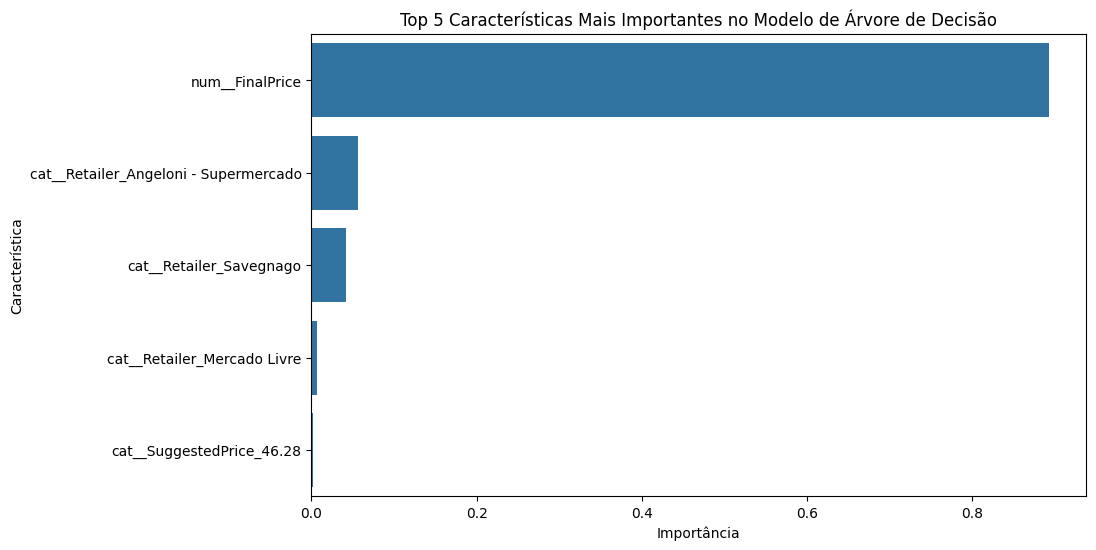

In [ ]:


# Extrair importâncias das características do modelo de árvore de decisão
importances = pipeline_dt.named_steps['classifier'].feature_importances_

# Obter os nomes das características após o pré-processamento
feature_names = pipeline_dt.named_steps['preprocessor'].get_feature_names_out()

# Adicionar o nome da nova coluna criada pelo IsoForestTransformer
feature_names = list(feature_names) + ['iso_forest']

# Verificar o comprimento de importances e feature_names
print(f"Comprimento das importâncias: {len(importances)}")
print(f"Comprimento dos nomes das características: {len(feature_names)}")

# Criar um DataFrame com as importâncias e os nomes das características
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordenar o DataFrame pelas importâncias
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Selecionar as top 5 características
top_features = feature_importances.head(5)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 5 Características Mais Importantes no Modelo de Árvore de Decisão')
plt.xlabel('Importância')
plt.ylabel('Característica')
plt.show()


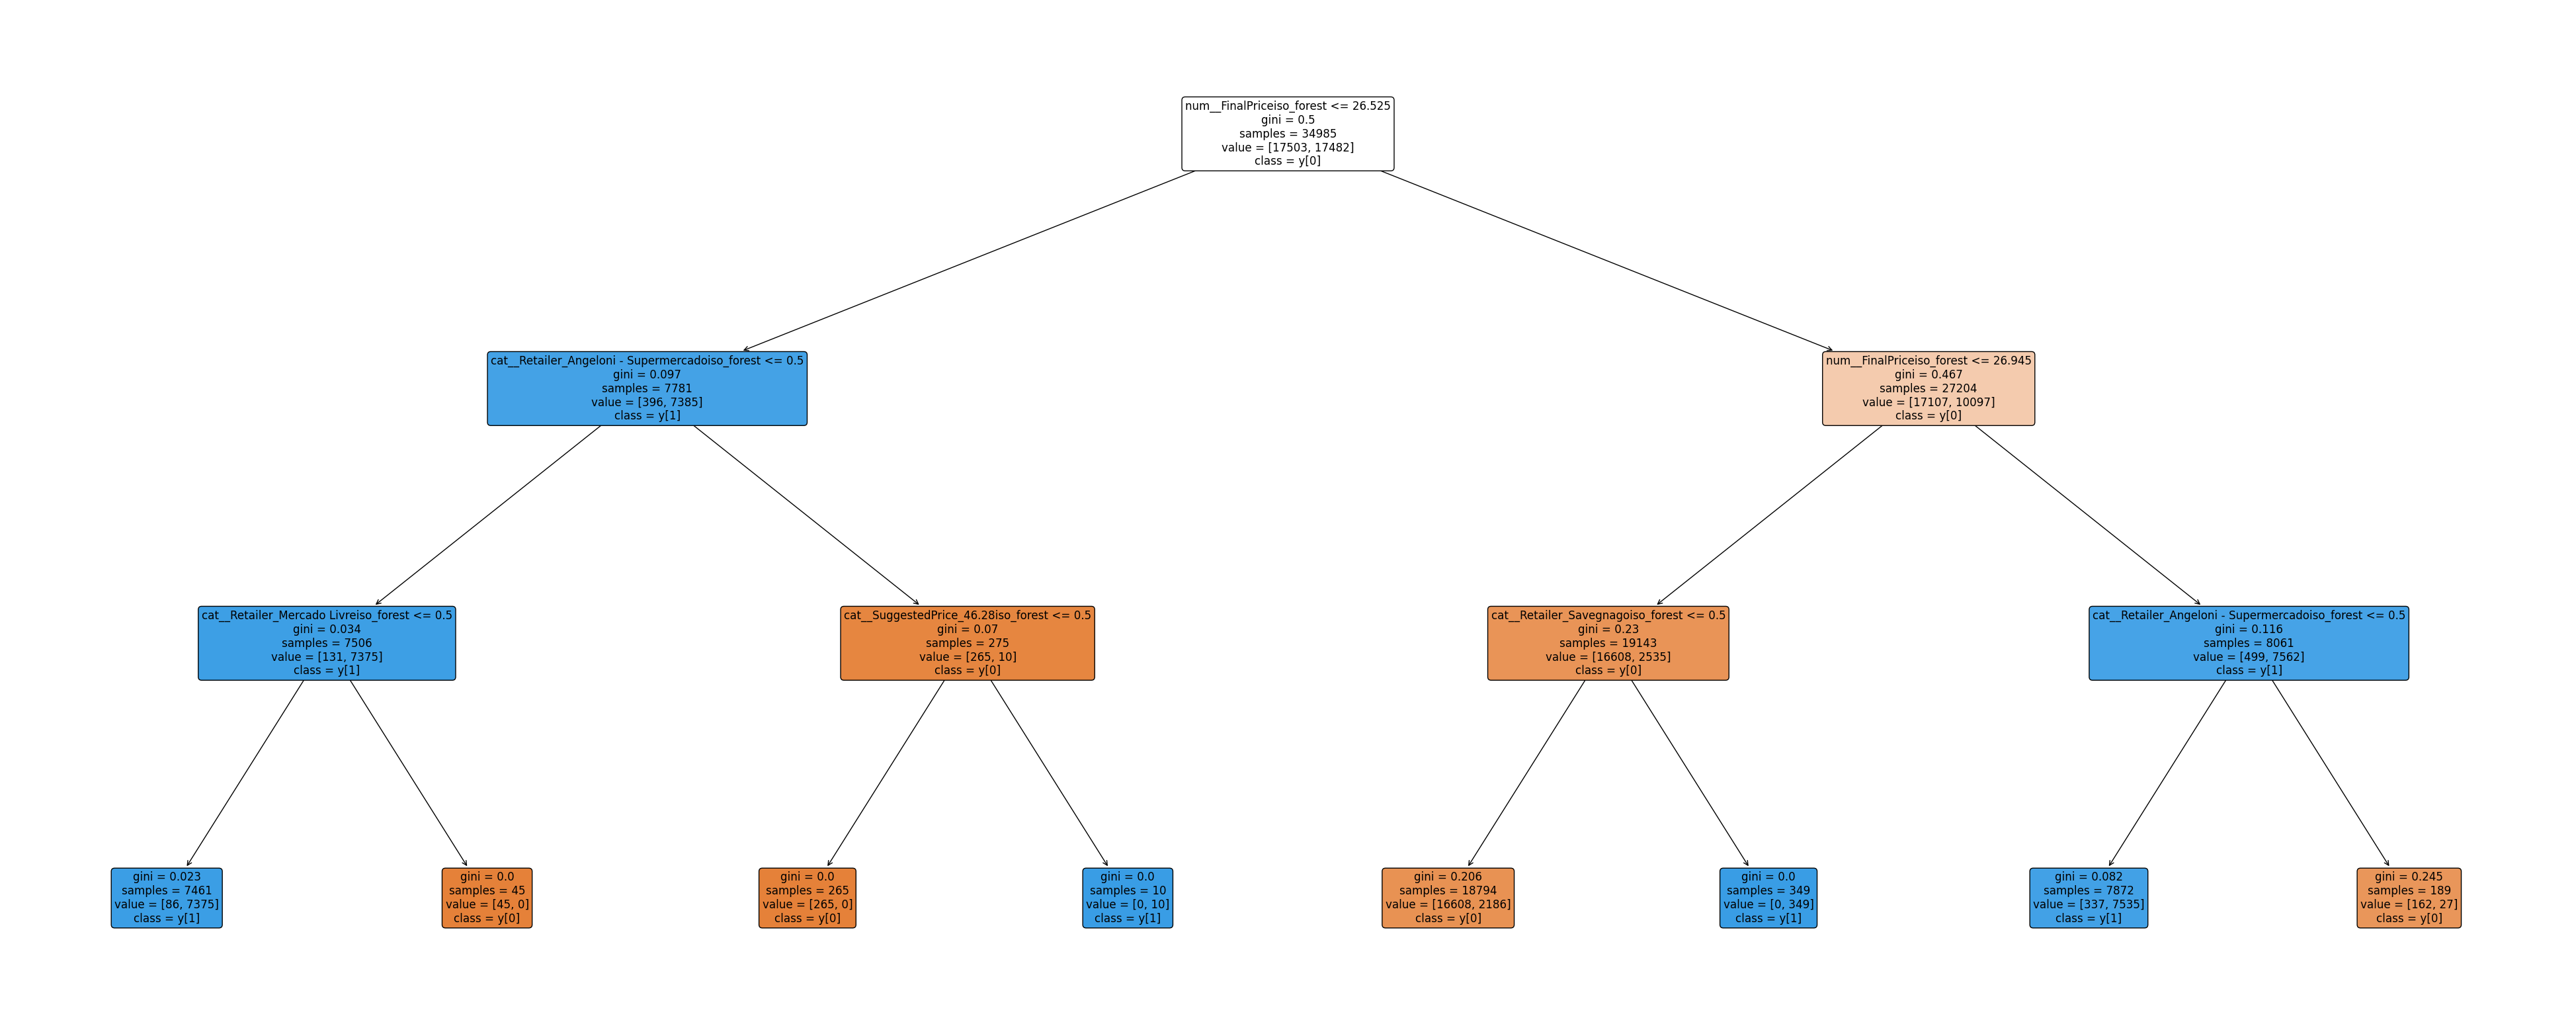

In [ ]:
# Plotar a árvore de decisão
plt.figure(figsize=(50, 20))
plot_tree(pipeline_dt.named_steps['classifier'], 
          feature_names=pipeline_dt.named_steps['preprocessor'].get_feature_names_out() + ['iso_forest'], 
          class_names=True, 
          filled=True, 
          rounded=True)
plt.show()


Validação Cruzada

In [ ]:
# Definir os parâmetros para o Grid Search detalhado
param_grid = [
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [2, 3]
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5]
    }
]

# Criar o objeto Grid Search com validação cruzada de 5 folds
grid_search = GridSearchCV(pipeline_cross_validation, param_grid, cv=5, scoring='accuracy')

# Treinar a pipeline
grid_search.fit(X_train, y_train)

# Obter o melhor modelo
best_model = grid_search.best_estimator_

# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

# Imprimir as previsões
print("Previsões:", y_pred)

# Exibir o melhor estimador encontrado pelo Grid Search
print("Melhor Estimador:")
print(best_model)

# Calcular e imprimir a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

Acurácia: 0.9973705270378416
Previsões: [0 1 0 ... 0 1 1]
Melhor Estimador:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['FinalPrice']),
                                                 ('cat', OneHotEncoder(),
                                                  ['SuggestedPrice',
                                                   'RandomPrecosNegativos',
                                                   'RandomPrecosDiscrepantes',
                                                   'Customer', 'Department',
                                                   'Category', 'Brand',
                                                   'Product', 'Retailer'])])),
                ('union',
                 FeatureUnion(transformer_list=[('preprocessed',
      

# Regressão Linear

essa regressão não foi feita com o balanceamento

In [32]:
path = "amostra_PETS.csv"
all_files = glob.glob(path + "/*.csv")
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

/tmp/ipykernel_83050/3119978930.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample('D').mean().fillna(method='ffill')  # Resample diário e preencher valores faltantes
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42204D+00    |proj g|=  3.90885D-01

At iterate    5    f=  3.27333D+00    |proj g|=  2.66622D-02

At iterate   10    f=  3.24681D+00    |proj g|=  4.26635D-02

At iterate   15    f=  3.21388D+00    |proj g|=  1.06138D-02

At iterate   20    f=  3.21100D+00    |proj g|=  5.49641D-03

At iterate   25    f=  3.21049D+00    |proj g|=  8.63423D-04

At iterate   30    f=  3.21042D+00    |proj g|=  2.79206D-04

At iterate   35    f=  3.21041D+00    |proj g|=  2.59307D-04

At iterate   40    f=  3.21041D+00    |proj g|=  8.25995D-05

At iterate   45    f=  3.21041D+00    |proj g|=  2.82835D-05

At iterate   50    f=  3.21041D+00    |proj g|=  5.86668D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/kelvin/anaconda3/envs/pyspark/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


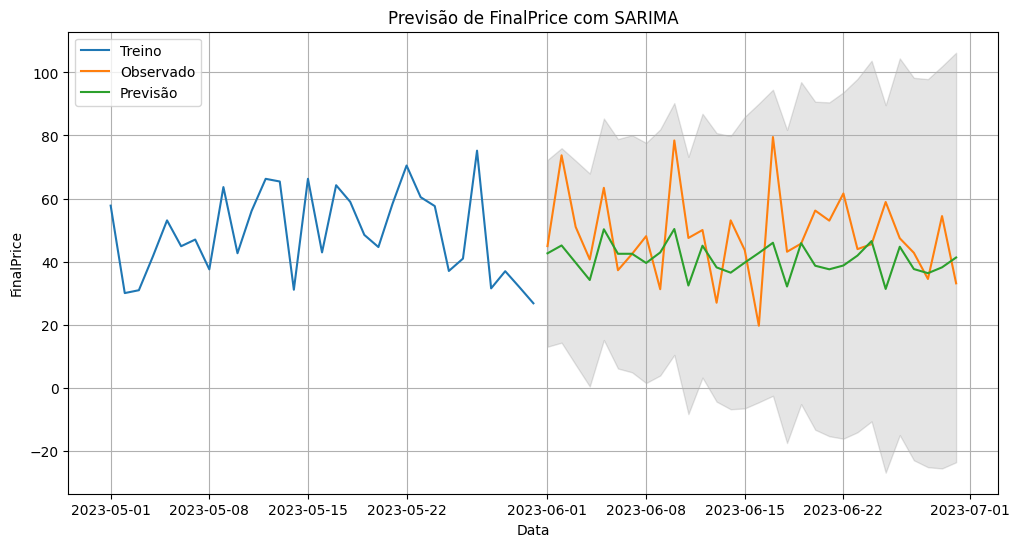

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Verificar se as colunas necessárias estão presentes
required_columns = ['FinalPrice', 'Ano', 'Mês', 'Dia']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Coluna '{col}' não encontrada no DataFrame.")

# Filtrar as colunas relevantes
df = df[required_columns]

# Renomear as colunas para o formato esperado pelo statsmodels
df.rename(columns={'Ano': 'year', 'Mês': 'month', 'Dia': 'day', 'FinalPrice': 'target'}, inplace=True)

# Converter para o formato de data
df['ds'] = pd.to_datetime(df[['year', 'month', 'day']])
df.set_index('ds', inplace=True)
df = df.resample('D').mean().fillna(method='ffill')  # Resample diário e preencher valores faltantes


train = df.iloc[:-30]  # Treino com todos os dados exceto os últimos 30 dias
test = df.iloc[-30:]   # Teste com os últimos 30 dias

# Definir o modelo SARIMA
model = SARIMAX(train['target'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Exemplo de ordem SARIMA

# Ajustar o modelo aos dados
results = model.fit()

# Fazer previsões para os próximos 30 dias
forecast = results.get_forecast(steps=30)

# Obter intervalos de confiança
forecast_ci = forecast.conf_int()

# Ajustar as previsões ao índice correto
y_pred = forecast.predicted_mean.reindex(test.index)

# Calcular métricas de erro
mae = mean_absolute_error(test['target'], y_pred)
mse = mean_squared_error(test['target'], y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test['target'] - y_pred) / test['target'])) * 100

# Plotar as previsões e os dados observados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['target'], label='Treino')
plt.plot(test.index, test['target'], label='Observado')
plt.plot(y_pred.index, y_pred, label='Previsão')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title('Previsão de FinalPrice com SARIMA')
plt.xlabel('Data')
plt.ylabel('FinalPrice')
plt.legend()
plt.grid(True)
plt.show()


Linha Verde (Treino): Representa os dados de treino, que são todos os dados exceto os últimos 30 dias que foram reservados para teste. Esses dados são usados para treinar o modelo SARIMA.

Linha Azul (Observado): São os dados reais dos últimos 30 dias que você separou como conjunto de teste. Esses dados são usados para verificar a precisão das previsões do modelo.

Linha Laranja (Previsão): Representa as previsões feitas pelo modelo SARIMA para os últimos 30 dias do conjunto de teste. Essas previsões são calculadas após ajustar o modelo com os dados de treino.


In [34]:
print(f"Erro Médio Absoluto (MAE): {mae:.2f}")
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")
print(f"Erro Percentual Absoluto Médio (MAPE): {mape:.2f}%")

Erro Médio Absoluto (MAE): 11.85
Erro Quadrático Médio (MSE): 227.89
Raiz do Erro Quadrático Médio (RMSE): 15.10
Erro Percentual Absoluto Médio (MAPE): 24.84%


PREVISAO DE JULHO

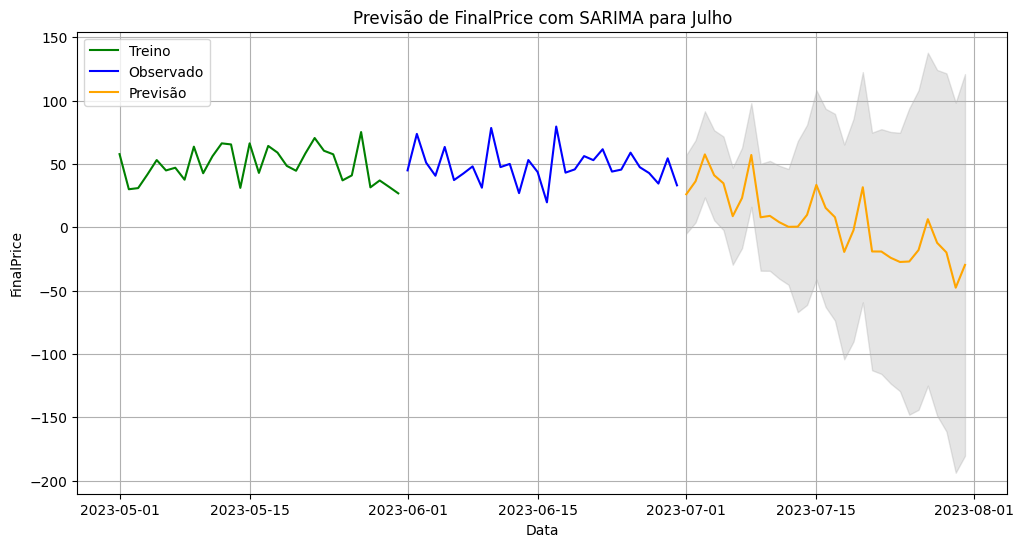

In [28]:
df['ds'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df[['ds', 'target']]

# Separar dados de treino e teste
train = df[df['ds'] < '2023-06-01']
test = df[df['ds'] >= '2023-06-01']

# Ajustar o modelo SARIMA
model = SARIMAX(train['target'], order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
fit_model = model.fit(disp=False)

# Fazer previsões para o mês de julho (próximo mês)
forecast = fit_model.get_forecast(steps=31)  # 31 dias para todo o mês de julho

# Extrair as previsões e o intervalo de confiança
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Adicionar datas para plotagem
forecast_index = pd.date_range(start='2023-07-01', periods=len(forecast_mean), freq='D')

# Visualizar as previsões para o mês de julho
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['target'], label='Treino', color='green')
plt.plot(test['ds'], test['target'], label='Observado', color='blue')
plt.plot(forecast_index, forecast_mean, label='Previsão', color='orange')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.title('Previsão de FinalPrice com SARIMA para Julho')
plt.xlabel('Data')
plt.ylabel('FinalPrice')
plt.legend()
plt.grid(True)
plt.show()

# Graficos

In [ ]:
!pip install graphviz
!pip install pydotplus


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 KB 1.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=f876112ba6866e8b2dd7f7d45f1617a7ed7fcedc8ca10d4e7f7b54cea6d98341
  Stored in directory: /home/kelvin/.cache/pip/wheels/69/b2/67/08f0eef649af92df772c09f451558298e07fab1bc7cdf33db0
Successfully built pydotplus
